## Business Question : do Irish petrol prices go up and down in line with the world crude oil price (aka Brent crude oil price)

### Import relevent Libraries

In [3]:
# import the pandas the library
import pandas as pd
import numpy as np
# import the warnings file so we can supress unnecessary warnings when running code
import warnings
warnings.filterwarnings('ignore')   # The object 'warnings' is used to call the method 'filterwarnings' and ignore the warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for KNN model
from sklearn.neighbors import KNeighborsRegressor
# for decision tree
from sklearn.tree import DecisionTreeRegressor
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# for the time series model
from statsmodels.tsa.arima.model import ARIMA
# Import linear regression model
from sklearn.linear_model import LinearRegression
# Import necessary evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# imoport for visualisations 
import matplotlib.pyplot as plt
import seaborn as sns

### Import data sets : 3 datasets to import , brent (daily), eur-usd (daily), Irish petrol (monthly) and merge them into a combined dataset with approx 5000 rows and 12 columns. 

In [2]:
# import the file on brent crude, cleaned the data and split out the date in year month day to have a key for a merge 
df_brent = pd.read_csv('./dataset/brent_oil2000-2022.csv')
# import the file on IRISH PETROL AND DIESEL PRICES AA, cleaned it in excel from a original pdf and  
# split out the date in year month day to have a key for a merge
df_irish_petrol = pd.read_csv('./dataset/IrelandPetrolPrices_1991-2022.csv')
# import eur-usd rate from 1999-2022
# also cleaned the data to split out the date in year month day to have a key for a merge
df_eur_usd = pd.read_csv('./dataset/euro-USD-hist_1999_2022.csv')

## Data Preperation

In [6]:
# define some functions i use to clean data
# function to Rename columns in a given DataFrame, df (target pandas DataFrame), 
# current_names (list): a list of current column names to be renamed
# new_names (list): a list of new column names to replace current names  
def rename_columns(df, current_names, new_names):
    if len(current_names) != len(new_names):
        raise ValueError("current_names and new_names should have the same length")
    mapping = dict(zip(current_names, new_names))
    df = df.rename(columns=mapping)
    return df

# function to Rename row data in a given columns in a given DataFrame, df (target pandas DataFrame), 
# col_name colum you want to target,  changes (list) an array of the changes
def rename_row_data(df, col_name, changes):
    for old_val, new_val in changes.items():
        df.loc[df[col_name] == old_val, col_name] = new_val

In [7]:
df_brent.shape, df_irish_petrol.shape, df_eur_usd.shape

NameError: name 'df_brent' is not defined

In [5]:
df_brent

,Date,year,month,day,Open,High,Low,Close,Volume,Currency
0,04/01/2000,2000,1,4,23.90,24.70,23.89,24.39,32509,USD
1,05/01/2000,2000,1,5,24.25,24.37,23.70,23.73,30310,USD
2,06/01/2000,2000,1,6,23.55,24.22,23.35,23.62,44662,USD
3,07/01/2000,2000,1,7,23.57,23.98,23.05,23.09,34826,USD
4,10/01/2000,2000,1,10,23.04,23.78,23.04,23.73,26388,USD
...,...,...,...,...,...,...,...,...,...,...
5817,29/08/2022,2022,8,29,98.96,103.22,98.25,102.93,211627,USD
5818,30/08/2022,2022,8,30,102.88,103.48,96.63,97.84,356096,USD
5819,31/08/2022,2022,8,31,98.33,99.00,94.40,95.64,290425,USD
5820,01/09/2022,2022,9,1,93.88,94.24,90.72,91.32,264968,USD


In [6]:
df_irish_petrol

,index,year,MMM,month,day,unleaded,diesel
0,2.0,2022.0,Dec,12.0,1.0,160.00,173.90
1,3.0,2022.0,Nov,11.0,1.0,177.30,196.10
2,4.0,2022.0,Oct,10.0,1.0,183.30,202.50
3,5.0,2022.0,Sept,9.0,1.0,183.90,193.70
4,6.0,2022.0,Aug,8.0,1.0,186.90,189.80
...,...,...,...,...,...,...,...
358,550.0,1992.0,Feb,2.0,1.0,75.04,68.31
359,551.0,1992.0,Jan,1.0,1.0,75.04,68.31
360,554.0,1991.0,dec,12.0,1.0,75.04,68.31
361,559.0,1991.0,Nov,11.0,1.0,75.42,68.31


In [7]:
df_eur_usd

,year,month,day,eur-usd
0,1999,1,4,1.1789
1,1999,1,5,1.1790
2,1999,1,6,1.1743
3,1999,1,7,1.1632
4,1999,1,8,1.1659
...,...,...,...,...
6163,2023,1,23,1.0871
6164,2023,1,24,1.0858
6165,2023,1,25,1.0878
6166,2023,1,26,1.0895


In [8]:
# since brent is daily then need to fill in all missing days in irish dataset with data the same for all days ion the month. 

# Create a new dataframe with only the first day of each month from df_irish_petrol
df_irish_petrol_first_day = df_irish_petrol.groupby(['year', 'month']).first().reset_index()

# Merge df_brent and df_irish_petrol_first_day dataframes
df_merged = pd.merge(df_brent, df_irish_petrol_first_day, how='left', on=['year', 'month'])

# Forward fill the missing values in the merged dataframe
df_merged.fillna(method='ffill', inplace=True)

# Rename the columns to match the original column names
df_merged.rename(columns={'day_x': 'day', 'day_y': 'day_irish_petrol'}, inplace=True)

# Drop the redundant columns
#df_merged.drop(columns=['month_y'], inplace=True)

# Set the day column to integer type
df_merged['day'] = df_merged['day'].astype(int)

### Line Chart of closing prices by day

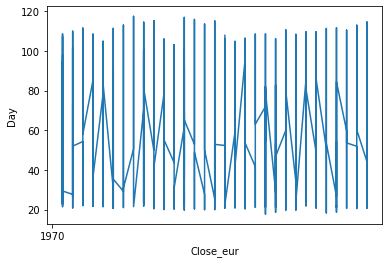

In [39]:
# Read the CSV file into a DataFrame
df = pd.read_csv('df_merged.csv')

# Convert the date column to a datetime object
df['day'] = pd.to_datetime(df['day'])

# Sort the DataFrame by date
df = df.sort_values('day')

# Create a line chart of the data over time
plt.plot(df['day'], df['Close_eur'])

# Set the x-axis label to 'Date' and the y-axis label to 'Column name'
plt.xlabel('Close_eur')
plt.ylabel('Day')

# Show the chart
plt.show()

In [9]:
unique_values = df_merged['year'].unique() # get the years i have data for
unique_values.sort() # sort it from oldest to newest
print(unique_values) # have a look at them

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [10]:
# Clean up columns, get rid of any columns that are not of use to us.
df_merged = df_merged.drop(['Date','index','MMM','day_irish_petrol','Currency'], axis=1)

In [11]:
# need to add $ eur conversion
# Merge df_eur_usd with df_merged
df_merged = pd.merge(df_merged, df_eur_usd, on=['year', 'month', 'day'], how='left')

# Convert crude_close from USD to EUR
df_merged['Close_eur'] = df_merged['Close'] / df_merged['eur-usd']

# Drop unnecessary columns
# df_merged.drop(['eur_usd'], axis=1, inplace=True)

# Verify the merged DataFrame
print(df_merged.head())

   year  month  day   Open   High    Low  Close  Volume  unleaded  diesel  \
0  2000      1    4  23.90  24.70  23.89  24.39   32509     82.79   78.22   
1  2000      1    5  24.25  24.37  23.70  23.73   30310     82.79   78.22   
2  2000      1    6  23.55  24.22  23.35  23.62   44662     82.79   78.22   
3  2000      1    7  23.57  23.98  23.05  23.09   34826     82.79   78.22   
4  2000      1   10  23.04  23.78  23.04  23.73   26388     82.79   78.22   

   eur-usd  Close_eur  
0   1.0305  23.668122  
1   1.0368  22.887731  
2   1.0388  22.737774  
3   1.0284  22.452353  
4   1.0229  23.198749  


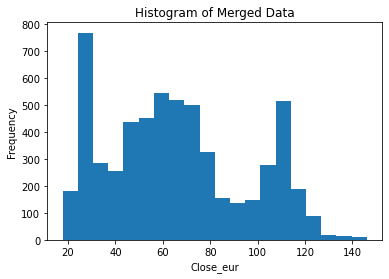

In [24]:
# Read the CSV file into a DataFrame
df = pd.read_csv('df_merged.csv')

# Create a histogram
plt.hist(df['Close'], bins=20)

# Set the x-label
plt.xlabel('Close_eur')

# Set the y-label
plt.ylabel('Frequency')

# Set the title
plt.title('Histogram of Merged Data')

# Show the plot
plt.show()

In [12]:
# Save the merged DataFrame to a CSV file
df_merged.to_csv('./dataset/df_merged.csv', index=False)
df_merged

,year,month,day,Open,High,Low,Close,Volume,unleaded,diesel,eur-usd,Close_eur
0,2000,1,4,23.90,24.70,23.89,24.39,32509,82.79,78.22,1.0305,23.668122
1,2000,1,5,24.25,24.37,23.70,23.73,30310,82.79,78.22,1.0368,22.887731
2,2000,1,6,23.55,24.22,23.35,23.62,44662,82.79,78.22,1.0388,22.737774
3,2000,1,7,23.57,23.98,23.05,23.09,34826,82.79,78.22,1.0284,22.452353
4,2000,1,10,23.04,23.78,23.04,23.73,26388,82.79,78.22,1.0229,23.198749
...,...,...,...,...,...,...,...,...,...,...,...,...
5817,2022,8,29,98.96,103.22,98.25,102.93,211627,186.90,189.80,0.9986,103.074304
5818,2022,8,30,102.88,103.48,96.63,97.84,356096,186.90,189.80,1.0034,97.508471
5819,2022,8,31,98.33,99.00,94.40,95.64,290425,186.90,189.80,1.0000,95.640000
5820,2022,9,1,93.88,94.24,90.72,91.32,264968,183.90,193.70,1.0004,91.283487


In [30]:
# Read the CSV file into a DataFrame
df = pd.read_csv('df_merged.csv')

# Use the .head() method to show the first 5 rows of the DataFrame
print(df.head())

   year  month  day   Open   High    Low  Close  Volume  unleaded  diesel  \
0  2000      1    4  23.90  24.70  23.89  24.39   32509     82.79   78.22   
1  2000      1    5  24.25  24.37  23.70  23.73   30310     82.79   78.22   
2  2000      1    6  23.55  24.22  23.35  23.62   44662     82.79   78.22   
3  2000      1    7  23.57  23.98  23.05  23.09   34826     82.79   78.22   
4  2000      1   10  23.04  23.78  23.04  23.73   26388     82.79   78.22   

   eur-usd  Close_eur  
0   1.0305  23.668122  
1   1.0368  22.887731  
2   1.0388  22.737774  
3   1.0284  22.452353  
4   1.0229  23.198749  


In [19]:
df = pd.read_csv('df_merged.csv')

print(df.columns.tolist())

['year', 'month', 'day', 'Open', 'High', 'Low', 'Close', 'Volume', 'unleaded', 'diesel', 'eur-usd', 'Close_eur']


In [13]:
# Calculate the correlation between "Close" and "Unleaded"
correlation_unleaded = df_merged['Close_eur'].corr(df_merged['unleaded'])

# Calculate the correlation between "Close" and "Diesel"
correlation_diesel = df_merged['Close_eur'].corr(df_merged['diesel'])

print("Correlation between Close and Unleaded: ", correlation_unleaded)
print("Correlation between Close and Diesel: ", correlation_diesel)

Correlation between Close and Unleaded:  0.8721063495503939
Correlation between Close and Diesel:  0.8999506964266666


In [14]:
print(df_merged.dtypes)

year           int64
month          int64
day            int32
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
unleaded     float64
diesel       float64
eur-usd      float64
Close_eur    float64
dtype: object


In [17]:
# Remove rows with missing values as the models crash with error NaN if blank cells
df_merged = df_merged.dropna()

## Machine Learning Models 

In [18]:
#KNN model

# Split the data into features (X) and target (y)
X = df_merged.drop(['unleaded', 'diesel'], axis=1)  # Features (all columns except 'unleaded' and 'diesel')
y_unleaded = df_merged['unleaded']  # Target variable 'unleaded'
y_diesel = df_merged['diesel']  # Target variable 'diesel'

# Split the data into training and testing sets
X_train, X_test, y_unleaded_train, y_unleaded_test = train_test_split(X, y_unleaded, test_size=0.2, random_state=42)
X_train, X_test, y_diesel_train, y_diesel_test = train_test_split(X, y_diesel, test_size=0.2, random_state=42)

# Create and fit KNN models
knn_unleaded = KNeighborsRegressor(n_neighbors=5)  # KNN model for 'unleaded'
knn_diesel = KNeighborsRegressor(n_neighbors=5)  # KNN model for 'diesel'
knn_unleaded.fit(X_train, y_unleaded_train)
knn_diesel.fit(X_train, y_diesel_train)

# Predict on the test set
y_unleaded_pred = knn_unleaded.predict(X_test)
y_diesel_pred = knn_diesel.predict(X_test)

# Calculate and print the mean squared error (MSE) for the predictions
mse_unleaded = mean_squared_error(y_unleaded_test, y_unleaded_pred)
mse_diesel = mean_squared_error(y_diesel_test, y_diesel_pred)
print("MSE for 'unleaded':", mse_unleaded)
print("MSE for 'diesel':", mse_diesel)

MSE for 'unleaded': 312.2872112941177
MSE for 'diesel': 377.3116284048443


In [19]:
# decison tree

# Split the data into features (X) and target (y)
X = df_merged.drop(['unleaded', 'diesel'], axis=1)  # Features (all columns except 'unleaded' and 'diesel')
y_unleaded = df_merged['unleaded']  # Target variable 'unleaded'
y_diesel = df_merged['diesel']  # Target variable 'diesel'

# Split the data into training and testing sets
X_train, X_test, y_unleaded_train, y_unleaded_test = train_test_split(X, y_unleaded, test_size=0.2, random_state=42)
X_train, X_test, y_diesel_train, y_diesel_test = train_test_split(X, y_diesel, test_size=0.2, random_state=42)

# Create and fit decision tree models
dt_unleaded = DecisionTreeRegressor(max_depth=5)  # Decision tree model for 'unleaded'
dt_diesel = DecisionTreeRegressor(max_depth=5)  # Decision tree model for 'diesel'
dt_unleaded.fit(X_train, y_unleaded_train)
dt_diesel.fit(X_train, y_diesel_train)

# Predict on the test set
y_unleaded_pred = dt_unleaded.predict(X_test)
y_diesel_pred = dt_diesel.predict(X_test)

# Calculate and print the mean squared error (MSE) for the predictions
mse_unleaded = mean_squared_error(y_unleaded_test, y_unleaded_pred)
mse_diesel = mean_squared_error(y_diesel_test, y_diesel_pred)
print("MSE for 'unleaded':", mse_unleaded)
print("MSE for 'diesel':", mse_diesel)

MSE for 'unleaded': 16.333673763893852
MSE for 'diesel': 25.429166425580735


In [20]:
# random forest 

# Split the dataset into features (X) and target (y)
X = df_merged.drop(['unleaded', 'diesel'], axis=1)  # Features: all columns except 'unleaded' and 'diesel'
y_unleaded = df_merged['unleaded']  # Target: 'unleaded' prices
y_diesel = df_merged['diesel']  # Target: 'diesel' prices

# Split the data into training and testing sets
X_train, X_test, y_unleaded_train, y_unleaded_test, y_diesel_train, y_diesel_test = train_test_split(X, y_unleaded, y_diesel, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regression model for 'unleaded' prices
rf_unleaded = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed
rf_unleaded.fit(X_train, y_unleaded_train)

# Make predictions on the test set for 'unleaded' prices
y_unleaded_pred = rf_unleaded.predict(X_test)

# Evaluate the model for 'unleaded' prices
mse_unleaded = mean_squared_error(y_unleaded_test, y_unleaded_pred)
r2_unleaded = r2_score(y_unleaded_test, y_unleaded_pred)
print("Mean Squared Error (MSE) for 'unleaded' prices: ", mse_unleaded)
print("R-squared (R2) for 'unleaded' prices: ", r2_unleaded)

# Initialize and train the Random Forest Regression model for 'diesel' prices
rf_diesel = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed
rf_diesel.fit(X_train, y_diesel_train)

# Make predictions on the test set for 'diesel' prices
y_diesel_pred = rf_diesel.predict(X_test)

# Evaluate the model for 'diesel' prices
mse_diesel = mean_squared_error(y_diesel_test, y_diesel_pred)
r2_diesel = r2_score(y_diesel_test, y_diesel_pred)
print("Mean Squared Error (MSE) for 'diesel' prices: ", mse_diesel)
print("R-squared (R2) for 'diesel' prices: ", r2_diesel)


Mean Squared Error (MSE) for 'unleaded' prices:  0.6975990948356365
R-squared (R2) for 'unleaded' prices:  0.9990886516378475
Mean Squared Error (MSE) for 'diesel' prices:  1.4954428911678161
R-squared (R2) for 'diesel' prices:  0.9982449523100944


In [ ]:
# Time based model 
# Assuming df_merged has columns 'year', 'month', 'day', 'petrol_price', and 'crude_oil_price_eur'

# Combine year, month, and day columns into a single 'date' column
df_merged['date'] = pd.to_datetime(df_merged[['year', 'month', 'day']])
df_merged.set_index('date', inplace=True)

# Create ARIMA model for petrol price
p=10
d=10
q=10
model = ARIMA(df_merged['unleaded'], order=(p, d, q))
model_fit = model.fit()

# Get predicted values
predictions = model_fit.predict(start='2000-01-01', end='2022-09-20')  # Replace with desired date range

# Compare predicted values with actual crude oil price in EUR
# You can calculate correlation, perform statistical tests, or visualize the relationship


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# liner regression
# Data Preparation: Make sure your dataframe (e.g., df_merged) is properly prepared for modeling. 
# This may involve handling missing values, converting data types, scaling or normalizing variables, 
# and splitting the data into training and testing sets. For example:
        

# Prepare data
X = df_merged[['Close_eur']]  # Independent variable (feature)
y = df_merged['unleaded']  # Dependent variable (target)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Model Training: Fit the linear regression model using the training data. For example:

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)


In [ ]:
# Model Evaluation: Evaluate the performance of the trained model using appropriate 
# evaluation metrics such as RMSE, MAE, R-squared, and others. For example:


# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)



In [ ]:
# Model Prediction: Once the model is trained and evaluated, you can use it to make 
# predictions on new, unseen data. For example:

# Make predictions on new data - pop in some data here to see the predictions
new_data = pd.DataFrame({'Close_eur': [50.0, 100.0, 150.0, 250.0]})  # Example new data
predicted_prices = model.predict(new_data)

# Print predicted prices
print("Predicted petrol prices: ", predicted_prices)
